Shape of the samples: torch.Size([10000, 2]) torch.Size([10000, 2])


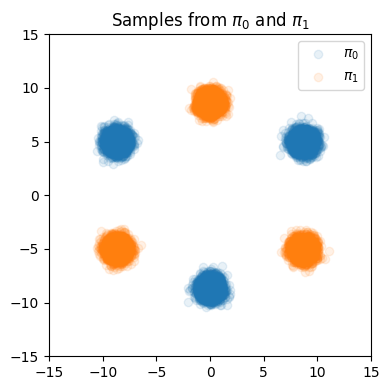

In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.distributions import Normal, Categorical
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.mixture_same_family import MixtureSameFamily
import matplotlib.pyplot as plt
import torch.nn.functional as F

D = 10.
M = D+5
VAR = 0.3
DOT_SIZE = 4
COMP = 3

initial_mix = Categorical(torch.tensor([1/COMP for i in range(COMP)]))
initial_comp = MultivariateNormal(torch.tensor([[D * np.sqrt(3) / 2., D / 2.], [-D * np.sqrt(3) / 2., D / 2.], [0.0, - D * np.sqrt(3) / 2.]]).float(), VAR * torch.stack([torch.eye(2) for i in range(COMP)]))
initial_model = MixtureSameFamily(initial_mix, initial_comp)
samples_0 = initial_model.sample([10000])

target_mix = Categorical(torch.tensor([1/COMP for i in range(COMP)]))
target_comp = MultivariateNormal(torch.tensor([[D * np.sqrt(3) / 2., - D / 2.], [-D * np.sqrt(3) / 2., - D / 2.], [0.0, D * np.sqrt(3) / 2.]]).float(), VAR * torch.stack([torch.eye(2) for i in range(COMP)]))
target_model = MixtureSameFamily(target_mix, target_comp)
samples_1 = target_model.sample([10000])
print('Shape of the samples:', samples_0.shape, samples_1.shape)

plt.figure(figsize=(4,4))
plt.xlim(-M,M)
plt.ylim(-M,M)
plt.title(r'Samples from $\pi_0$ and $\pi_1$')
plt.scatter(samples_0[:, 0].cpu().numpy(), samples_0[:, 1].cpu().numpy(), alpha=0.1, label=r'$\pi_0$')
plt.scatter(samples_1[:, 0].cpu().numpy(), samples_1[:, 1].cpu().numpy(), alpha=0.1, label=r'$\pi_1$')
plt.legend()

plt.tight_layout()

torch.Size([10000, 2, 2])


Text(0.5, 1.0, 'Training Loss Curve')

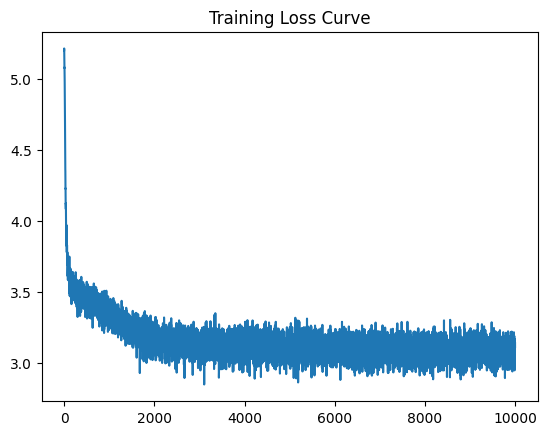

In [2]:
class MLP(nn.Module):
    def __init__(self, input_dim=2, hidden_num=100):
        super().__init__()
        self.fc1 = nn.Linear(input_dim+1, hidden_num, bias=True)
        self.fc2 = nn.Linear(hidden_num, hidden_num, bias=True)
        self.fc3 = nn.Linear(hidden_num, input_dim, bias=True)
        self.act = lambda x: torch.tanh(x)
    
    def forward(self, x_input, t):
        inputs = torch.cat([x_input, t], dim=1)
        x = self.fc1(inputs)
        x = self.act(x)
        x = self.fc2(x)
        x = self.act(x)
        x = self.fc3(x)

        return x
    

class RectifiedFlow():
  def __init__(self, model=None, num_steps=1000):
    self.model = model
    self.N = num_steps
  
  def get_train_tuple(self, z0=None, z1=None):
    t = torch.rand((z1.shape[0], 1))
    z_t =  t * z1 + (1.-t) * z0
    target = z1 - z0 
        
    return z_t, t, target

  @torch.no_grad()
  def sample_ode(self, z0=None, N=None):
    ### NOTE: Use Euler method to sample from the learned flow
    if N is None:
      N = self.N    
    dt = 1./N
    traj = [] # to store the trajectory
    z = z0.detach().clone()
    batchsize = z.shape[0]
    
    traj.append(z.detach().clone())
    for i in range(N):
      t = torch.ones((batchsize,1)) * i / N
      pred = self.model(z, t)
      z = z.detach().clone() + pred * dt
      
      traj.append(z.detach().clone())

    return traj
  

def train_rectified_flow(rectified_flow, optimizer, pairs, batchsize, inner_iters):
  loss_curve = []
  for i in range(inner_iters+1):
    optimizer.zero_grad()
    indices = torch.randperm(len(pairs))[:batchsize]
    batch = pairs[indices]
    z0 = batch[:, 0].detach().clone()
    z1 = batch[:, 1].detach().clone()
    z_t, t, target = rectified_flow.get_train_tuple(z0=z0, z1=z1)

    pred = rectified_flow.model(z_t, t)
    loss = (target - pred).view(pred.shape[0], -1).abs().pow(2).sum(dim=1)
    loss = loss.mean()
    loss.backward()
    
    optimizer.step()
    loss_curve.append(np.log(loss.item())) ## to store the loss curve

  return rectified_flow, loss_curve


@torch.no_grad()
def draw_plot(rectified_flow, z0, z1, N=None):
  traj = rectified_flow.sample_ode(z0=z0, N=N)
  
  plt.figure(figsize=(4,4))
  plt.xlim(-M,M)
  plt.ylim(-M,M)
    
  plt.scatter(z1[:, 0].cpu().numpy(), z1[:, 1].cpu().numpy(), label=r'$\pi_1$', alpha=0.15)
  plt.scatter(traj[0][:, 0].cpu().numpy(), traj[0][:, 1].cpu().numpy(), label=r'$\pi_0$', alpha=0.15)
  plt.scatter(traj[-1][:, 0].cpu().numpy(), traj[-1][:, 1].cpu().numpy(), label='Generated', alpha=0.15)
  plt.legend()
  plt.title('Distribution')
  plt.tight_layout()

  traj_particles = torch.stack(traj)
  plt.figure(figsize=(4,4))
  plt.xlim(-M,M)
  plt.ylim(-M,M)
  plt.axis('equal')
  for i in range(30):
    plt.plot(traj_particles[:, i, 0], traj_particles[:, i, 1])
  plt.title('Transport Trajectory')
  plt.tight_layout()

x_0 = samples_0.detach().clone()[torch.randperm(len(samples_0))]
x_1 = samples_1.detach().clone()[torch.randperm(len(samples_1))]
x_pairs = torch.stack([x_0, x_1], dim=1)
print(x_pairs.shape)

iterations = 10000
batchsize = 2048
input_dim = 2

rectified_flow_1 = RectifiedFlow(model=MLP(input_dim, hidden_num=100), num_steps=100)
optimizer = torch.optim.Adam(rectified_flow_1.model.parameters(), lr=5e-3)

rectified_flow_1, loss_curve = train_rectified_flow(rectified_flow_1, optimizer, x_pairs, batchsize, iterations)
plt.plot(np.linspace(0, iterations, iterations+1), loss_curve[:(iterations+1)])
plt.title('Training Loss Curve')



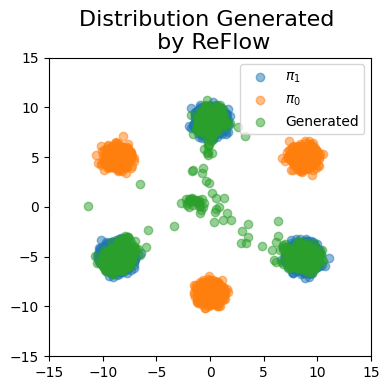

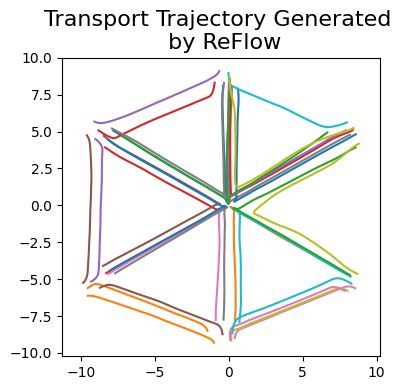

In [10]:

# import os

@torch.no_grad()
def draw_plot(rectified_flow, z0, z1, N=None):
  traj = rectified_flow.sample_ode(z0=z0, N=N)
  
  plt.figure(figsize=(4,4))
  plt.xlim(-M,M)
  plt.ylim(-M,M)
    
  plt.scatter(z1[:, 0].cpu().numpy(), z1[:, 1].cpu().numpy(), label=r'$\pi_1$', alpha=0.5)
  plt.scatter(traj[0][:, 0].cpu().numpy(), traj[0][:, 1].cpu().numpy(), label=r'$\pi_0$', alpha=0.5)
  plt.scatter(traj[-1][:, 0].cpu().numpy(), traj[-1][:, 1].cpu().numpy(), label='Generated', alpha=0.5)
  plt.legend()
  plt.title('Distribution Generated \n by ReFlow', fontsize=16)
  plt.tight_layout()

#   save as pdf
  plt.savefig('rectified_flow_distribution.pdf', format='pdf')

  traj_particles = torch.stack(traj)
  plt.figure(figsize=(4,4))
  plt.xlim(-M,M)
  plt.ylim(-M,M)
  plt.axis('equal')
  for i in range(30):
    plt.plot(traj_particles[:, i, 0], traj_particles[:, i, 1])
  plt.title('Transport Trajectory Generated \n by ReFlow', fontsize=16)
  plt.tight_layout()

  plt.savefig('rectified_flow_traj.pdf', format='pdf')

draw_plot(rectified_flow_1, z0=initial_model.sample([2000]), z1=samples_1.detach().clone(), N=100)